# Experimental data

In [1]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from tapqir.models import SpotDetection, Empirical
from pyro import param

In [2]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, \
                            precision_score, recall_score, \
                            roc_curve, roc_auc_score

from scipy.io import loadmat

## Orange dye non-attenuated data

Tracker v1.1.3flat

In [4]:
results = {}
predictions = {}
labels = {}
snr = []

#names = ["FL_5555_6684_1p3OD", "FL_4445_5554_1p1OD", "FL_3339_4444_0p8OD",
#         "FL_2226_3338_0p6OD", "FL_1118_2225_0p3OD", "FL_1_1117_0OD"]
names = ["FL_1118_2225_0p3OD"]

for name in names:
    path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
    path_params = os.path.join(path_data, "runs/spotdetection/v1.1.5/S1/nocontrol/lr0.005/bs5")
    results[name] = pd.read_csv(
        os.path.join(path_params, "global_params.csv"),
        header=None, squeeze=True, index_col=0)
    model = SpotDetection(S=1, K=2)
    model.load(path_data, False, "cpu")
    model.load_parameters(path_params)
    predictions[name] = model.z_marginal.numpy()
    labels[name] = np.load(os.path.join(path_data, "labels.npy"))
    
    model = Spotdetection(S=1)
    model.load(path_data, False, "cpu")
    model.load_parameters(path_params)
    snr.append(float(model.snr().mean()))

In [19]:
path_data = "/shared/centaur/data/test/GraceArticlePol2/"
path_params = os.path.join(path_data, "runs/spotdetection/v1.1.5/S1/nocontrol/lr0.005/bs8")
#results[name] = pd.read_csv(
#    os.path.join(path_params, "global_params.csv"),
#    header=None, squeeze=True, index_col=0)
model = SpotDetection(S=1, K=2)
model.load(path_data, False, "cpu")
model.load_parameters(path_params)
#predictions[name] = model.z_marginal.numpy()
#labels[name] = np.load(os.path.join(path_data, "labels.npy"))

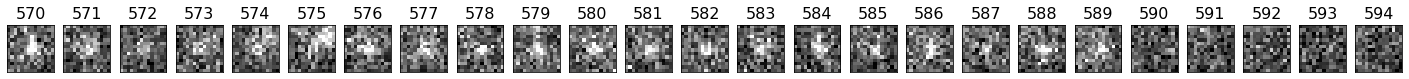

In [116]:
plt.figure(figsize=(25,3))
for i in range(25):
    plt.subplot(1, 25, i+1)
    plt.tick_params(
    axis="both",          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off
    plt.title(570+i, fontsize=16)
    plt.imshow(model.data[8, 570+i].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
plt.show()

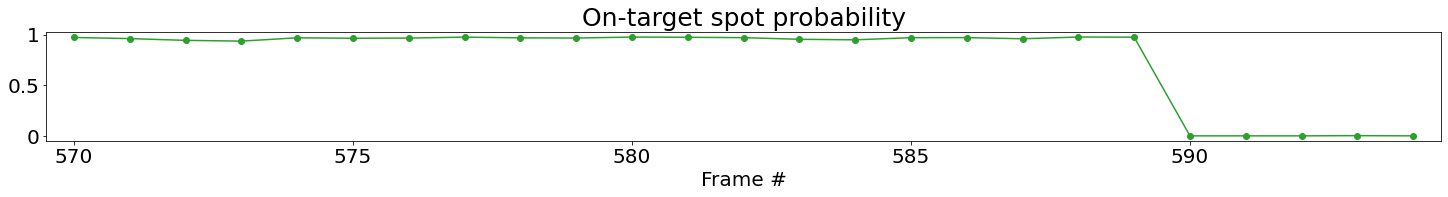

In [38]:
plt.figure(figsize=(25,2))
plt.plot(np.arange(570,595), model.z_marginal[8, 570:570+25].numpy(), "o-", c="C2")
plt.xlim(569.5, 594.5)
plt.title("On-target spot probability", fontsize=25)
plt.xlabel("Frame #", fontsize=20)
#plt.ylabel("Probability", fontsize=20)
#plt.gca().axes.get_xaxis().set_ticks(np.arange(6)*0.4)
plt.gca().axes.get_yaxis().set_ticks(np.arange(3)*0.5)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

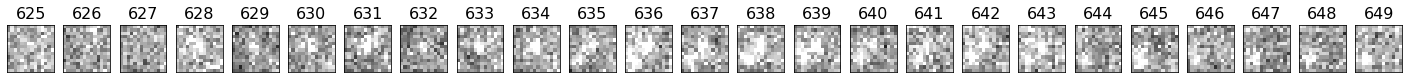

In [4]:
plt.figure(figsize=(25,3))
for i in range(25):
    plt.subplot(1, 25, i+1)
    plt.tick_params(
    axis="both",          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off
    plt.title(625+i, fontsize=16)
    plt.imshow(model.data[163, 625+i].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
plt.show()

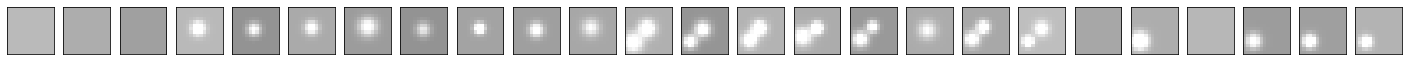

In [20]:
plt.figure(figsize=(25,3))
for i in range(25):
    plt.subplot(1, 25, i+1)
    plt.tick_params(
    axis="both",          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off
    #plt.title(625+i, fontsize=16)
    img_ideal = model.offset_mean + param("d/b_loc").data[n, f1:f2, None, None]
    gaussian = model.data_loc(
        param("d/h_loc").data[n, f1:f2].masked_fill(model.m_probs[n, f1:f2, :, 1]<0.5, 0.),
        #param("d/h_loc").data[n, f1:f2],
        param("d/w_mean").data[n, f1:f2],
        param("d/x_mean").data[n, f1:f2],
        param("d/y_mean").data[n, f1:f2],
        n, torch.arange(f1,f2)
    )
    img_ideal = img_ideal + gaussian.sum(-3)
    plt.imshow(img_ideal[i].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
plt.show()

In [152]:
n

163

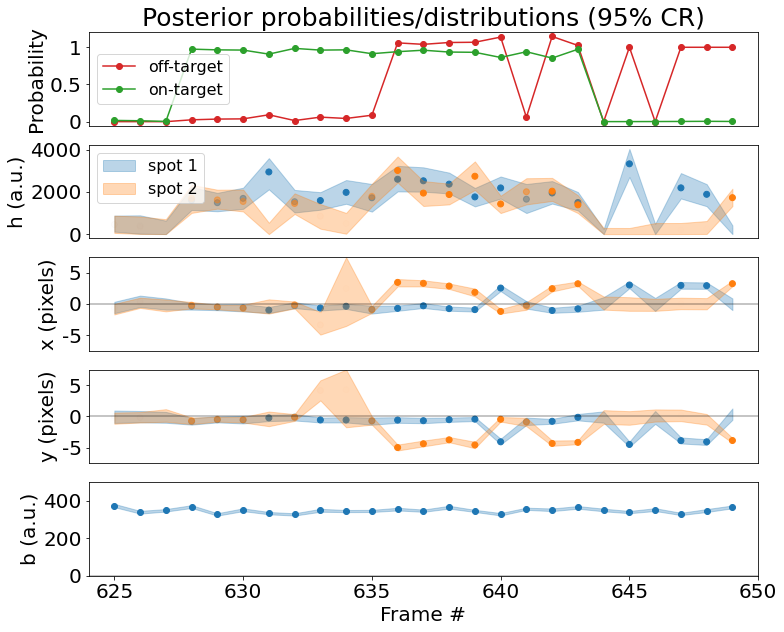

In [15]:
from matplotlib.colors import to_rgba_array
from pyro.ops.stats import hpdi
from tapqir.distributions import AffineBeta
n = 163
f1 = 625
f2 = 650
plt.figure(figsize=(12,10))
plt.subplot(5,1,1)
plt.plot(np.arange(f1,f2), model.j_probs[n, f1:f2, :, 1].sum(-1).numpy(), "o-", c="C3", label="off-target")
plt.plot(np.arange(f1,f2), model.z_marginal[n, f1:f2].numpy(), "o-", c="C2", label="on-target")
plt.xlim(f1-1, f2)
plt.title("Posterior probabilities/distributions (95% CR)", fontsize=25)
#plt.xlabel("Frame #", fontsize=20)
plt.legend(loc="center left", fontsize=16)
plt.ylabel("Probability", fontsize=20)
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().axes.get_yaxis().set_ticks(np.arange(3)*0.5)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=20)
plt.yticks(size=20)

m_colors = np.zeros((2, f2-f1, 4))
m_colors[0] += to_rgba_array("C0")
m_colors[0, :, 3] = torch.min(model.m_probs[n, f1:f2, 0, 1], torch.tensor(1.))
m_colors[1] += to_rgba_array("C1")
m_colors[1, :, 3] = torch.min(model.m_probs[n, f1:f2, 1, 1], torch.tensor(1.))

z_colors = np.zeros((2, f2-f1, 4))
z_colors[0] += to_rgba_array("C2")
z_colors[0, :, 3] = torch.min(model.z_probs[n, f1:f2, 0, 1], torch.tensor(1.))
z_colors[1] += to_rgba_array("C2")
z_colors[1, :, 3] = torch.min(model.z_probs[n, f1:f2, 1, 1], torch.tensor(1.))

j_colors = np.zeros((2, f2-f1, 4))
j_colors[0] += to_rgba_array("C3")
j_colors[0, :, 3] = torch.min(model.j_probs[n, f1:f2, 0, 1], torch.tensor(1.))
j_colors[1] += to_rgba_array("C3")
j_colors[1, :, 3] = torch.min(model.j_probs[n, f1:f2, 1, 1], torch.tensor(1.))

plt.subplot(5,1,2)

hpd = hpdi(dist.Gamma(
                param("d/h_loc").data[n, f1:f2]
                * param("d/h_beta").data[n, f1:f2],
                param("d/h_beta").data[n, f1:f2])
                .sample((500,)), 0.95, dim=0)
for k in range(2):
    plt.fill_between(
        np.arange(f1,f2), hpd[0, :, k], hpd[1, :, k],
        where=model.m_probs[n, f1:f2, k, 1]>0., color="C{}".format(k), alpha=0.3, label="spot {}".format(k+1))
    plt.scatter(np.arange(f1,f2), param("d/h_loc").data[n, f1:f2, k].numpy(), c=m_colors[k])

#for k in range(2):
#    plt.fill_between(
#        np.arange(f1,f2), hpd[0, :, k], hpd[1, :, k],
#        where=model.j_probs[n, f1:f2, k, 1]>0.5, color="C3", alpha=0.3)
#    plt.scatter(np.arange(f1,f2), param("d/h_loc").data[n, f1:f2, k].numpy(), c=j_colors[k])

plt.xlim(f1-1, f2)
#plt.title("On-target spot probability", fontsize=25)
#plt.xlabel("Frame #", fontsize=20)
plt.legend(loc="upper left", fontsize=16)
plt.ylabel("h (a.u.)", fontsize=20)
plt.gca().axes.get_xaxis().set_ticks([])
#plt.gca().axes.get_yaxis().set_ticks(np.arange(3)*0.5)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=20)
plt.yticks(size=20)

plt.subplot(5,1,3)
plt.hlines(0, f1-1, f2, color="k", alpha=0.3)
hpd = hpdi(AffineBeta(
                param("d/x_mean").data[n, f1:f2],
                param("d/size").data[n, f1:f2],
                -7.5, 7.5)
                .sample((500,)), 0.95, dim=0)
for k in range(2):
    plt.fill_between(
        np.arange(f1,f2), hpd[0, :, k], hpd[1, :, k],
        where=model.z_probs[n, f1:f2, k, 1]>0., color="C{}".format(k), alpha=0.3)
    plt.scatter(np.arange(f1,f2), param("d/x_mean").data[n, f1:f2, k].numpy(), c=m_colors[k])

#for k in range(2):
#    plt.fill_between(
#        np.arange(f1,f2), hpd[0, :, k], hpd[1, :, k],
#        where=model.j_probs[n, f1:f2, k, 1]>0.5, color="C3", alpha=0.3)
#    plt.scatter(np.arange(f1,f2), param("d/x_mean").data[n, f1:f2, k].numpy(), c=j_colors[k])

plt.ylim(-7.5, 7.5)
plt.xlim(f1-1, f2)
#plt.title("On-target spot probability", fontsize=25)
#plt.xlabel("Frame #", fontsize=20)
plt.ylabel("x (pixels)", fontsize=20)
plt.gca().axes.get_xaxis().set_ticks([])
#plt.gca().axes.get_yaxis().set_ticks(np.arange(3)*0.5)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=20)
plt.yticks(size=20)

plt.subplot(5,1,4)
plt.hlines(0, f1-1, f2, color="k", alpha=0.3)
hpd = hpdi(AffineBeta(
                param("d/y_mean").data[n, f1:f2],
                param("d/size").data[n, f1:f2],
                -7.5, 7.5)
                .sample((500,)), 0.95, dim=0)
for k in range(2):
    plt.fill_between(
        np.arange(f1,f2), hpd[0, :, k], hpd[1, :, k],
        where=model.z_probs[n, f1:f2, k, 1]>0., color="C{}".format(k), alpha=0.3)
    plt.scatter(np.arange(f1,f2), param("d/y_mean").data[n, f1:f2, k].numpy(), c=m_colors[k])

#for k in range(2):
#    plt.fill_between(
#        np.arange(f1,f2), hpd[0, :, k], hpd[1, :, k],
#        where=model.j_probs[n, f1:f2, k, 1]>0.5, color="C3", alpha=0.3)
#    plt.scatter(np.arange(f1,f2), param("d/y_mean").data[n, f1:f2, k].numpy(), c=j_colors[k])

plt.ylim(-7.5, 7.5)
plt.xlim(f1-1, f2)
#plt.title("On-target spot probability", fontsize=25)
#plt.xlabel("Frame #", fontsize=20)
plt.ylabel("y (pixels)", fontsize=20)
plt.gca().axes.get_xaxis().set_ticks([])
#plt.gca().axes.get_yaxis().set_ticks(np.arange(3)*0.5)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=20)
plt.yticks(size=20)

plt.subplot(5,1,5)
plt.hlines(0, f1-1, f2, color="k", alpha=0.3)
hpd = hpdi(dist.Gamma(
                param("d/b_loc").data[n, f1:f2]
                * param("d/b_beta").data[n, f1:f2],
                param("d/b_beta").data[n, f1:f2])
                .sample((500,)), 0.95, dim=0)



plt.fill_between(
    np.arange(f1,f2), hpd[0, :], hpd[1, :],
    color="C0", alpha=0.3)
plt.scatter(np.arange(f1,f2), param("d/b_loc").data[n, f1:f2].numpy(), c="C0")

plt.ylim(0, 500)
plt.xlim(f1-1, f2)
#plt.title("On-target spot probability", fontsize=25)
plt.xlabel("Frame #", fontsize=20)
plt.ylabel("b (a.u.)", fontsize=20)
#plt.gca().axes.get_xaxis().set_ticks(np.arange(6)*0.4)
#plt.gca().axes.get_yaxis().set_ticks(np.arange(3)*0.5)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=20)
plt.yticks(size=20)


plt.show()

In [65]:
hpd.shape

torch.Size([2, 100, 2])

In [42]:
param("d/h_loc").data[8, 570:595].numpy()

array([[2572.3271 ,  254.60417],
       [2976.149  ,  210.10274],
       [1672.0327 , 1668.2046 ],
       [2369.9895 , 2213.7266 ],
       [2360.3594 , 1873.9706 ],
       [4322.531  , 1403.4468 ],
       [2553.2952 ,  811.59955],
       [2727.048  ,  262.60977],
       [1260.5383 , 1190.925  ],
       [1896.0513 ,  187.68349],
       [1856.0653 ,  347.73077],
       [2355.0327 ,  316.31805],
       [2081.1948 ,  209.36588],
       [2508.7104 ,  197.28453],
       [2563.7932 ,  291.98517],
       [1234.4385 , 1277.8102 ],
       [2087.8477 ,  404.53064],
       [ 825.7841 ,  877.6768 ],
       [2397.6199 ,  404.15353],
       [2397.4165 ,  300.85568],
       [ 125.01855,  120.38308],
       [ 124.94149,  137.45026],
       [ 122.01848,  128.9319 ],
       [ 301.4351 ,  322.8143 ],
       [ 116.78504,  108.17741]], dtype=float32)

In [ ]:
plt.figure(figsize=(25,2))
plt.plot(np.arange(570,595), model.z_marginal[8, 570:570+25].numpy(), "o-", c="C2")
plt.xlim(569.5, 594.5)
plt.title("On-target spot probability", fontsize=25)
plt.xlabel("Frame #", fontsize=20)
#plt.ylabel("Probability", fontsize=20)
#plt.gca().axes.get_xaxis().set_ticks(np.arange(6)*0.4)
plt.gca().axes.get_yaxis().set_ticks(np.arange(3)*0.5)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [24]:
df = pd.DataFrame(data=results).T.drop(columns=[float("nan"), "width_mean_0", "width_size_0"])
#df["SNR"] = snr
df

,iter,-ELBO,proximity_0,gain,logits_z_0,logits_z_1,rate_j,MCC,Recall,Precision,FN,TP,TN,FP
FL_5555_6684_1p3OD,29900.0,41262336.0,0.5,6.629405,0.980650,-2.361820,0.071292,0.918783,0.901798,0.939481,71.0,652.0,33736.0,42.0
FL_4445_5554_1p1OD,29900.0,30229094.0,0.5,6.734146,0.349147,-1.730404,0.055063,0.964969,0.965147,0.969044,52.0,1440.0,23006.0,46.0
FL_3339_4444_0p8OD,30000.0,36981384.0,0.5,6.678587,0.617833,-1.994053,0.039240,0.907296,0.963542,0.859466,28.0,740.0,26358.0,121.0
FL_2226_3338_0p6OD,29900.0,44427820.0,0.5,6.935335,0.421289,-1.812551,0.173906,0.961085,0.957995,0.968936,93.0,2121.0,33931.0,68.0
FL_1118_2225_0p3OD,29900.0,44877532.0,0.5,6.529236,1.028523,-2.409753,0.086012,0.930017,0.925620,0.937238,54.0,672.0,35449.0,45.0
FL_1_1117_0OD,29900.0,50181728.0,0.5,6.902276,1.081845,-2.462959,0.193352,0.903575,0.860792,0.951977,109.0,674.0,41865.0,34.0


0.997854512913911
0.9985858118188556
0.9965422185977566
0.9982159659140831
0.9984449317550431
0.9790159191124237


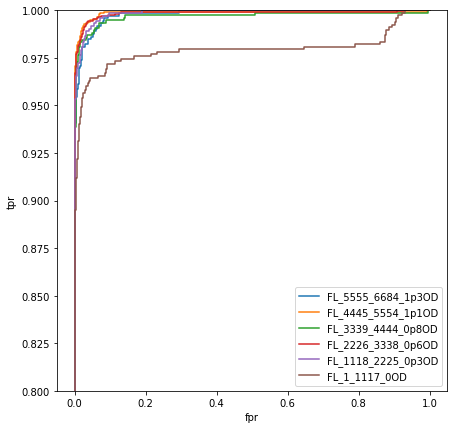

In [33]:
plt.figure(figsize=(7,7))
for name in names:
    mask = labels[name]["z"] < 2
    fpr, tpr, thresholds = roc_curve(labels[name]["z"][mask], predictions[name][mask])
    score = roc_auc_score(labels[name]["z"][mask], predictions[name][mask])
    print(score)
    plt.plot(fpr, tpr, label=name)
plt.xlabel("fpr")
plt.ylabel("tpr")

plt.legend()
plt.show()

In [37]:
results = {}
predictions = {}
true_labels = {}
snr = []

names = ["FL_2226_3338_0p6OD"]

for name in names:
    path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
    path_params = os.path.join(path_data, "runs/snr0/v1.1.5/S1/nocontrol/lr0.005/bs5")
    results[name] = pd.read_csv(
        os.path.join(path_params, "global_params.csv"),
        header=None, squeeze=True, index_col=0)
    model = SpotDetection(S=1, K=2)
    model.load(path_data, False, "cpu")
    model.load_parameters(path_params)
    predictions[name] = model.z_marginal.numpy()
    labels[name] = np.load(os.path.join(path_data, "labels.npy"))
    
    #model = Tracker(S=1)
    #model.load(path_data, False, "cpu")
    #model.load_parameters(path_params)
    #snr.append(float(model.snr().mean()))

/home/ordabayev/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


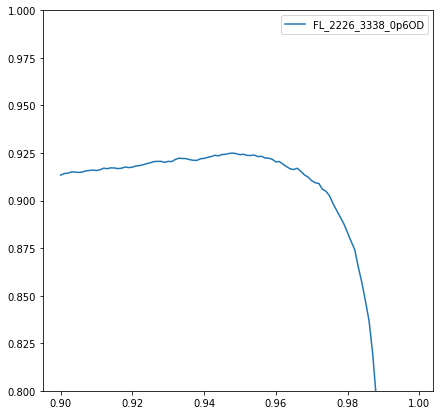

In [40]:
plt.figure(figsize=(7,7))
for name in names:
    mask = labels[name]["z"] < 2
    ts = np.arange(0.9,1,0.001)
    mcc = [matthews_corrcoef(labels[name]["z"][mask], predictions[name][mask]>t) for t in ts]
    plt.plot(ts, mcc, label=name)
plt.ylim(0.8,1)
plt.legend()
plt.show()

/home/ordabayev/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/ordabayev/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/ordabayev/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


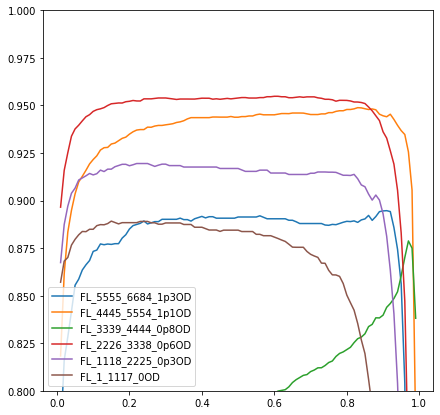

In [36]:
plt.figure(figsize=(7,7))
for name in names:
    mask = labels[name]["z"] < 2
    ts = np.arange(0.01,1,0.01)
    mcc = [matthews_corrcoef(labels[name]["z"][mask], predictions[name][mask]>t) for t in ts]
    plt.plot(ts, mcc, label=name)
plt.ylim(0.8,1)
plt.legend()
plt.show()

In [35]:
results = {}
predictions = {}
labels = {}
snr = []

names = ["FL_5555_6684_1p3OD", "FL_4445_5554_1p1OD", "FL_3339_4444_0p8OD",
         "FL_2226_3338_0p6OD", "FL_1118_2225_0p3OD", "FL_1_1117_0OD"]

for name in names:
    path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
    path_params = os.path.join(path_data, "runs/norm/v1.1.5/S1/nocontrol/lr0.005/bs5")
    results[name] = pd.read_csv(
        os.path.join(path_params, "global_params.csv"),
        header=None, squeeze=True, index_col=0)
    model = SpotDetection(S=1, K=2)
    model.load(path_data, False, "cpu")
    model.load_parameters(path_params)
    predictions[name] = model.z_marginal.numpy()
    labels[name] = np.load(os.path.join(path_data, "labels.npy"))

df = pd.DataFrame(data=results).T.drop(columns=[float("nan"), "width_mean_0", "width_size_0"])
df

,iter,-ELBO,proximity_0,gain,logits_z_0,logits_z_1,rate_j,MCC,Recall,Precision,FN,TP,TN,FP
FL_5555_6684_1p3OD,29900.0,40601212.0,0.5,6.747955,0.947896,-2.329014,0.108334,0.891349,0.900415,0.886921,72.0,651.0,33695.0,83.0
FL_4445_5554_1p1OD,22300.0,30189232.0,0.5,6.710896,0.382961,-1.764235,0.068506,0.943798,0.965818,0.929078,51.0,1441.0,22942.0,110.0
FL_3339_4444_0p8OD,29900.0,37149972.0,0.5,6.599391,0.513035,-1.889203,0.056673,0.792228,0.980469,0.650821,15.0,753.0,26075.0,404.0
FL_2226_3338_0p6OD,25900.0,43191356.0,0.5,6.780536,0.459670,-1.850928,0.198702,0.953896,0.958446,0.954995,92.0,2122.0,33899.0,100.0
FL_1118_2225_0p3OD,29900.0,44918032.0,0.5,6.583019,1.051078,-2.432301,0.099687,0.916850,0.915978,0.921053,61.0,665.0,35437.0,57.0
FL_1_1117_0OD,29900.0,49632520.0,0.5,6.803358,1.176146,-2.557266,0.176285,0.884434,0.832695,0.943560,131.0,652.0,41860.0,39.0


In [20]:
predictions["FL_5555_6684_1p3OD"].shape

(37, 1130)

0.9955881896496585
0.9977015771313625
0.9975174411011243
0.9980664982096158
0.9976455881807362
0.9889581517214799


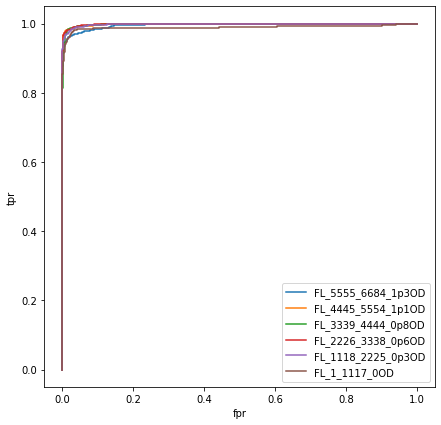

In [22]:
plt.figure(figsize=(7,7))
for name in names:
    mask = labels[name]["z"] < 2
    fpr, tpr, thresholds = roc_curve(labels[name]["z"][mask], predictions[name][mask])
    score = roc_auc_score(labels[name]["z"][mask], predictions[name][mask])
    print(score)
    plt.plot(fpr, tpr, label=name)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.show()

In [53]:
# load cosmos results
name = "FL_1_1117_0OD"
path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
path_params = os.path.join(path_data, "runs/empirical/v1.1.5/S1/nocontrol/lr0.005/bs5")
model = Empirical(S=1, K=2)
model.load(path_data, False, "cpu")
model.load_parameters(path_params)

torch.Size([48187, 14, 14])


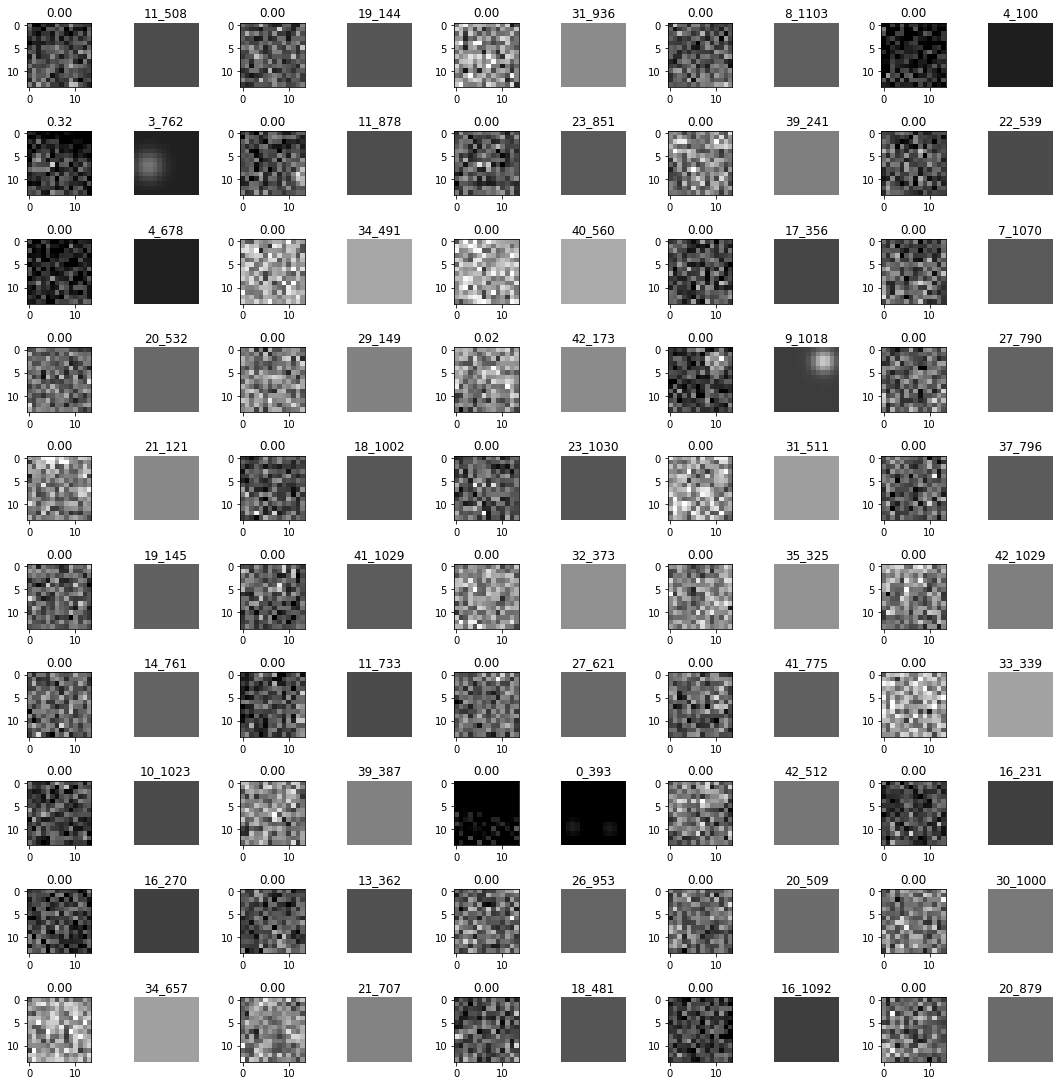

In [48]:
# spots missed by cosmos
mask = ((model.z_marginal.numpy() < 0.5))

n, f = np.nonzero(mask)
idx = np.arange(len(n))
np.random.shuffle(idx)

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,30))
for i in range(min(50, len(result))):
    j = idx[i]
    plt.subplot(20, 10, 2*i+1)
    
    gaussians = model.data_loc(
    param("d/h_loc").data[n[j], f[j]].masked_fill(model.m_probs[n[j], f[j], :, 1] < 0.5, 0.),
    param("d/w_mean").data[n[j], f[j]],
    param("d/x_mean").data[n[j], f[j]],
    param("d/y_mean").data[n[j], f[j]],
    n[j], f[j]).sum(-3)
    ideal = model.offset_mean + param("d/b_loc").data[n[j], f[j]] + gaussians
    plt.imshow(result[j].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.title("{:.2f}".format(model.z_marginal[n[j], f[j]]))
    
    plt.subplot(20, 10, 2*i+2)
    plt.title(f"{n[j]}_{f[j]}")
    plt.imshow(ideal.numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

torch.Size([71, 14, 14])


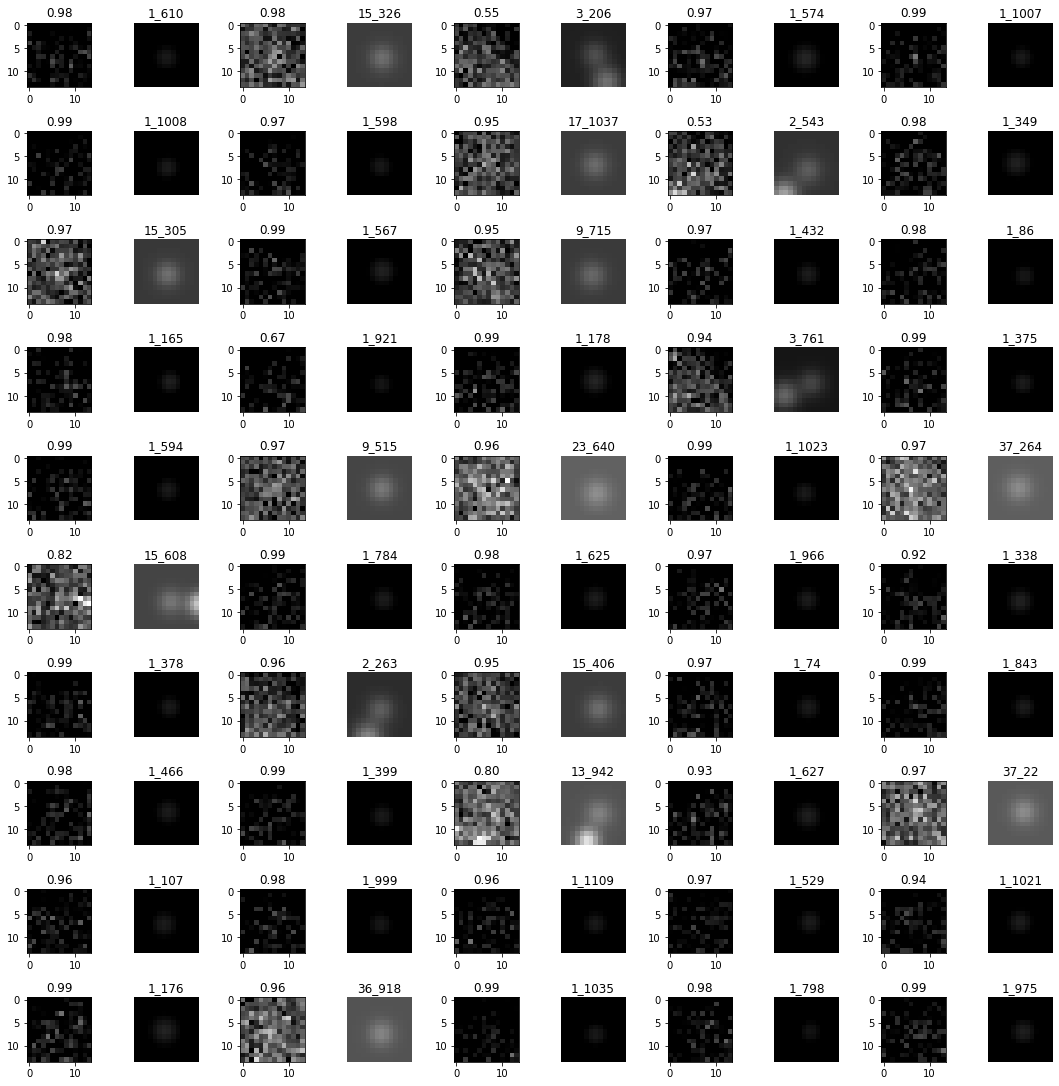

In [52]:
# spots missed by cosmos
mask = (((param("d/h_loc").data.numpy() < 1100) & (model.z_probs[..., 1].numpy() > 0.5))).sum(-1)

n, f = np.nonzero(mask)
idx = np.arange(len(n))
np.random.shuffle(idx)

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,30))
for i in range(min(50, len(result))):
    j = idx[i]
    plt.subplot(20, 10, 2*i+1)
    
    gaussians = model.data_loc(
    param("d/h_loc").data[n[j], f[j]].masked_fill(model.m_probs[n[j], f[j], :, 1] < 0.5, 0.),
    param("d/w_mean").data[n[j], f[j]],
    param("d/x_mean").data[n[j], f[j]],
    param("d/y_mean").data[n[j], f[j]],
    n[j], f[j]).sum(-3)
    ideal = model.offset_mean + param("d/b_loc").data[n[j], f[j]] + gaussians
    plt.imshow(result[j].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.title("{:.2f}".format(model.z_marginal[n[j], f[j]]))
    
    plt.subplot(20, 10, 2*i+2)
    plt.title(f"{n[j]}_{f[j]}")
    plt.imshow(ideal.numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

torch.Size([769, 14, 14])


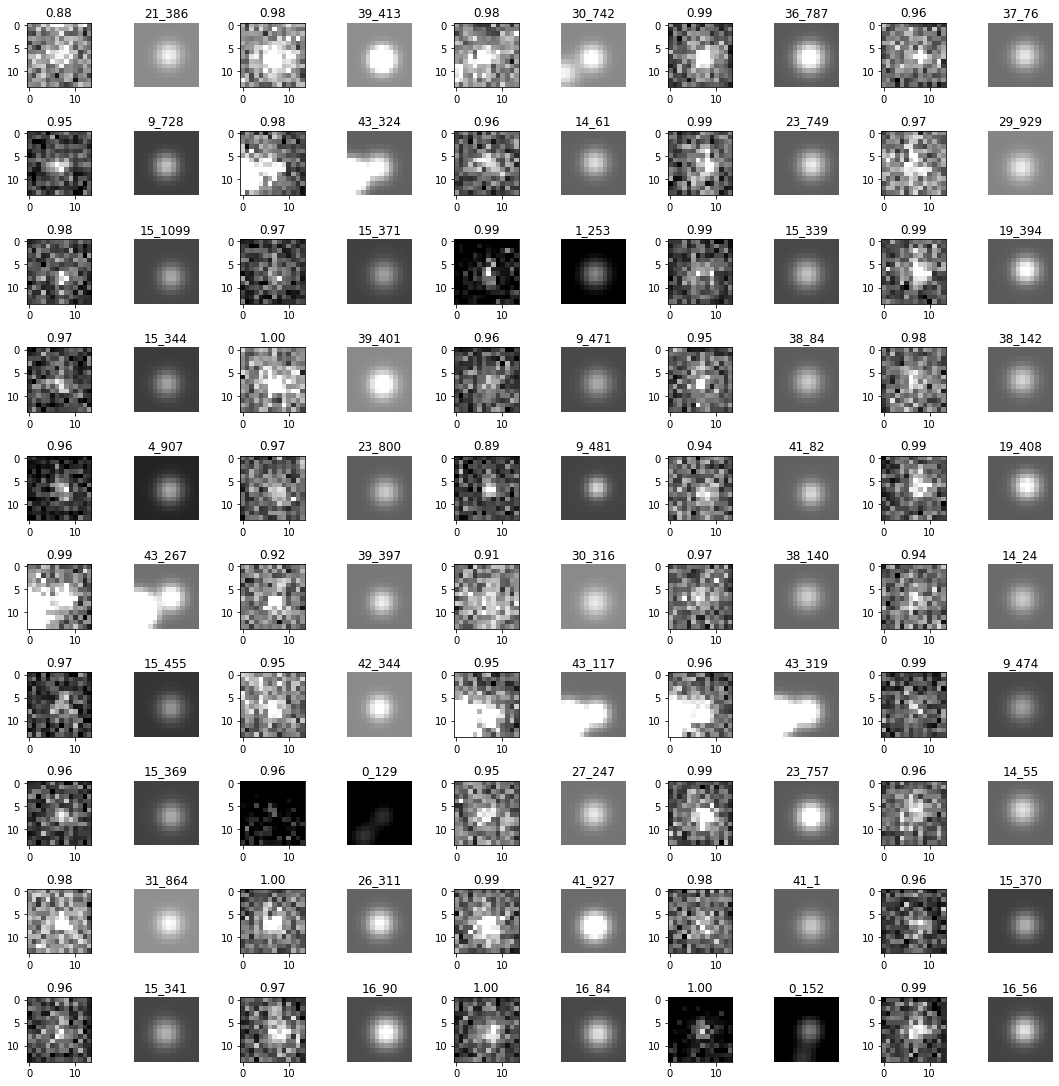

In [47]:
# spots missed by cosmos
mask = (((param("d/h_loc").data.numpy() > 2000) & (model.z_probs[..., 1].numpy() > 0.5))).sum(-1)

n, f = np.nonzero(mask)
idx = np.arange(len(n))
np.random.shuffle(idx)

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,30))
for i in range(min(50, len(result))):
    j = idx[i]
    plt.subplot(20, 10, 2*i+1)
    
    gaussians = model.data_loc(
    param("d/h_loc").data[n[j], f[j]].masked_fill(model.m_probs[n[j], f[j], :, 1] < 0.5, 0.),
    param("d/w_mean").data[n[j], f[j]],
    param("d/x_mean").data[n[j], f[j]],
    param("d/y_mean").data[n[j], f[j]],
    n[j], f[j]).sum(-3)
    ideal = model.offset_mean + param("d/b_loc").data[n[j], f[j]] + gaussians
    plt.imshow(result[j].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.title("{:.2f}".format(model.z_marginal[n[j], f[j]]))
    
    plt.subplot(20, 10, 2*i+2)
    plt.title(f"{n[j]}_{f[j]}")
    plt.imshow(ideal.numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

torch.Size([620, 14, 14])


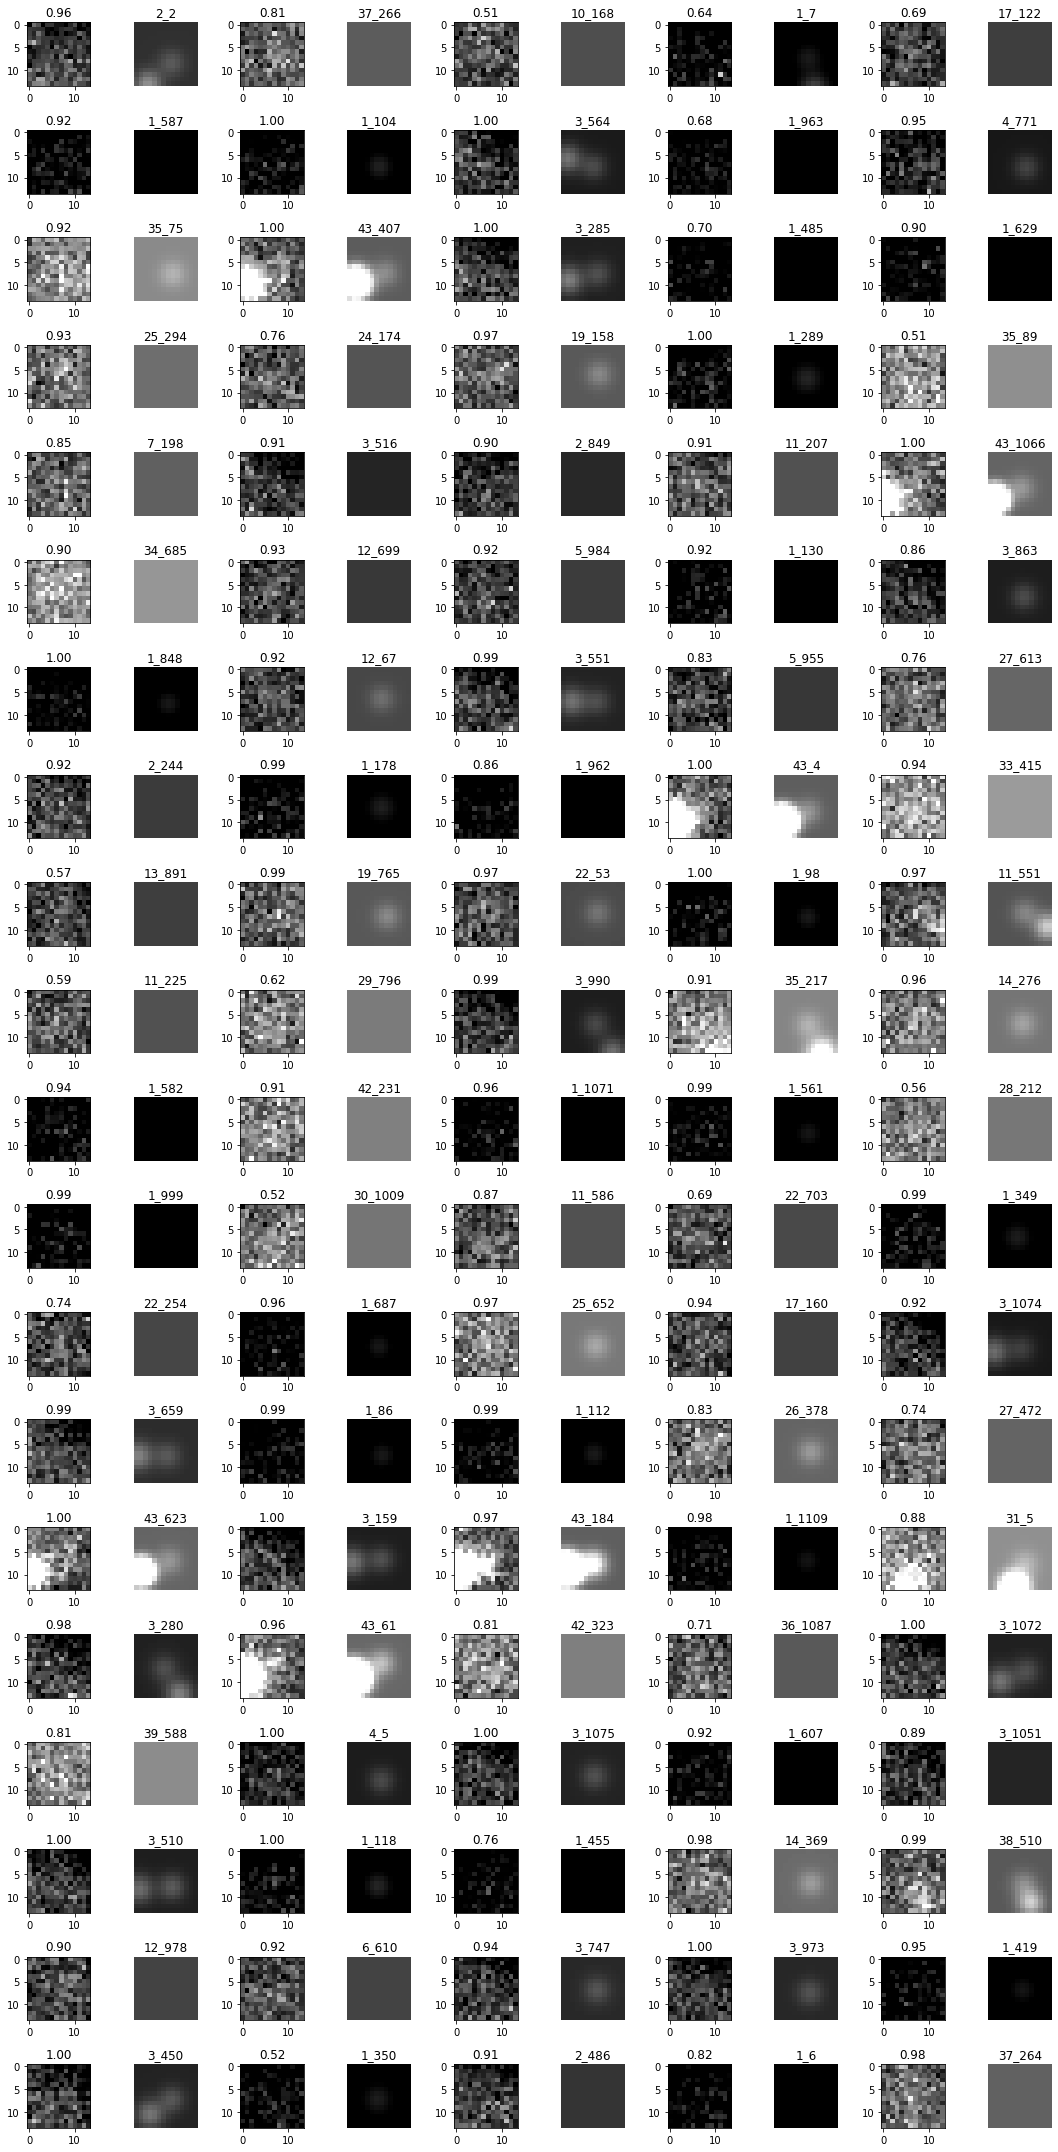

In [54]:
# spots missed by cosmos
mask = (((model.data.labels["z"] == 0) & (model.z_marginal.numpy() > 0.5)))

n, f = np.nonzero(mask)
idx = np.arange(len(n))
np.random.shuffle(idx)

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,30))
for i in range(min(100, len(result))):
    j = idx[i]
    plt.subplot(20, 10, 2*i+1)
    
    gaussians = model.data_loc(
    param("d/h_loc").data[n[j], f[j]].masked_fill(model.m_probs[n[j], f[j], :, 1] < 0.5, 0.),
    param("d/w_mean").data[n[j], f[j]],
    param("d/x_mean").data[n[j], f[j]],
    param("d/y_mean").data[n[j], f[j]],
    n[j], f[j]).sum(-3)
    ideal = model.offset_mean + param("d/b_loc").data[n[j], f[j]] + gaussians
    plt.imshow(result[j].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.title("{:.2f}".format(model.z_marginal[n[j], f[j]]))
    
    plt.subplot(20, 10, 2*i+2)
    plt.title(f"{n[j]}_{f[j]}")
    plt.imshow(ideal.numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# load cosmos results
name = "FL_1_1117_0OD"
path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
path_params = os.path.join(path_data, "runs/spotdetection/v1.1.5/S1/nocontrol/lr0.005/bs5")
model = SpotDetection(S=1, K=2)
model.load(path_data, False, "cpu")
model.load_parameters(path_params)

KeyError: 'probs_z'

torch.Size([111, 14, 14])


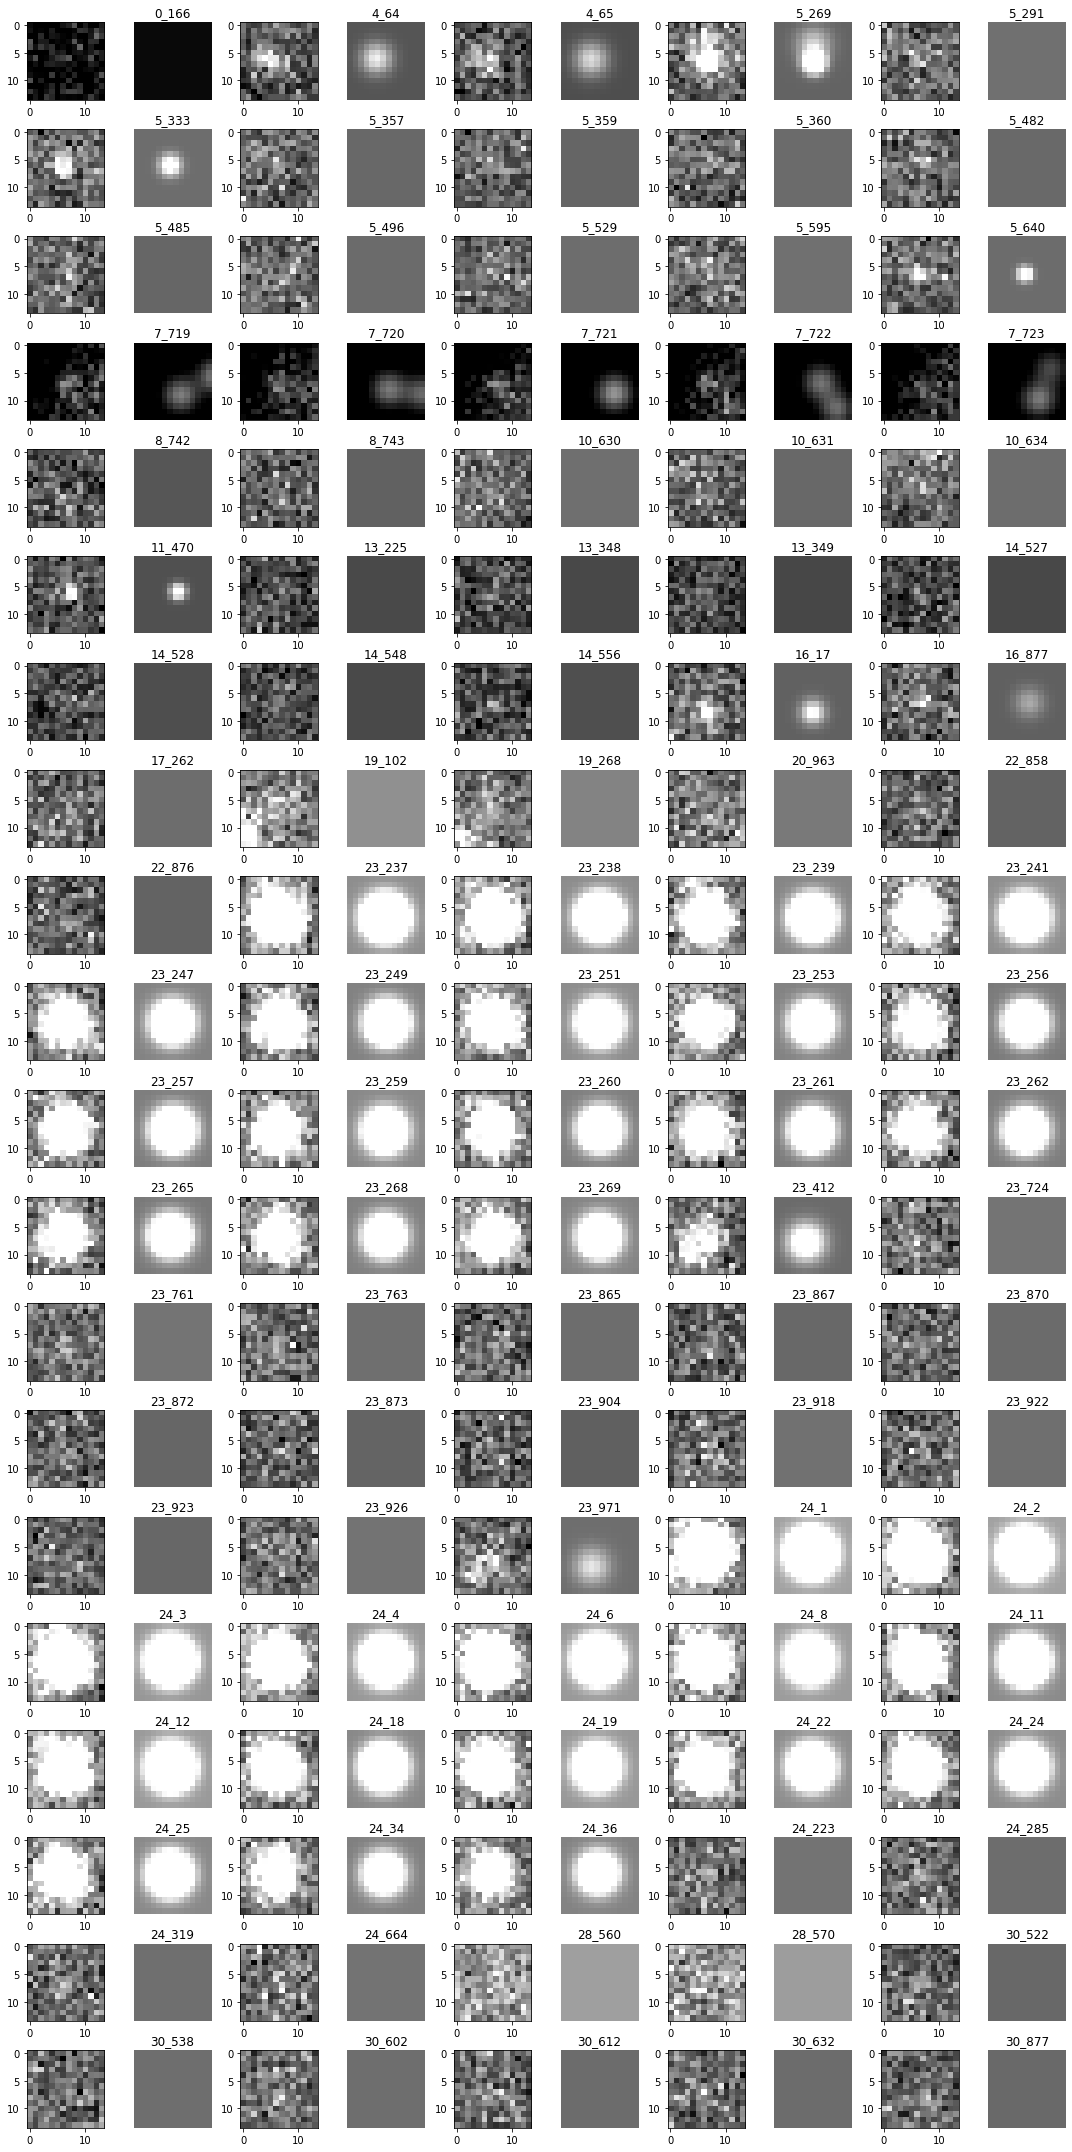

In [31]:
# spots missed by cosmos
mask = (((model.data.labels["z"] == 1) & (model.z_marginal.numpy() < 0.5)))

n, f = np.nonzero(mask)

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,30))
for i in range(min(100, len(result))):
    plt.subplot(20, 10, 2*i+1)
    gaussians = model.data_loc(
    param("d/h_loc").data[n[i], f[i]].masked_fill(model.m_probs[n[i], f[i], :, 1] < 0.5, 0.),
    param("d/w_mean").data[n[i], f[i]],
    param("d/x_mean").data[n[i], f[i]],
    param("d/y_mean").data[n[i], f[i]],
    n[i], f[i]).sum(-3)
    ideal = model.offset_mean + param("d/b_loc").data[n[i], f[i]] + gaussians
    plt.imshow(result[i].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    
    plt.subplot(20, 10, 2*i+2)
    plt.title(f"{n[i]}_{f[i]}")
    plt.imshow(ideal.numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [33]:
# load cosmos results
name = "GraceArticlePol2"
path_data = "/shared/centaur/data/test/{}".format(name)
path_params = os.path.join(path_data, "runs/multistate/v1.1.5/S1/nocontrol/lr0.005/bs8")
model = MultiState(S=1, K=2)
model.load(path_data, False, "cpu")
model.load_parameters(path_params)

torch.Size([2122, 14, 14])


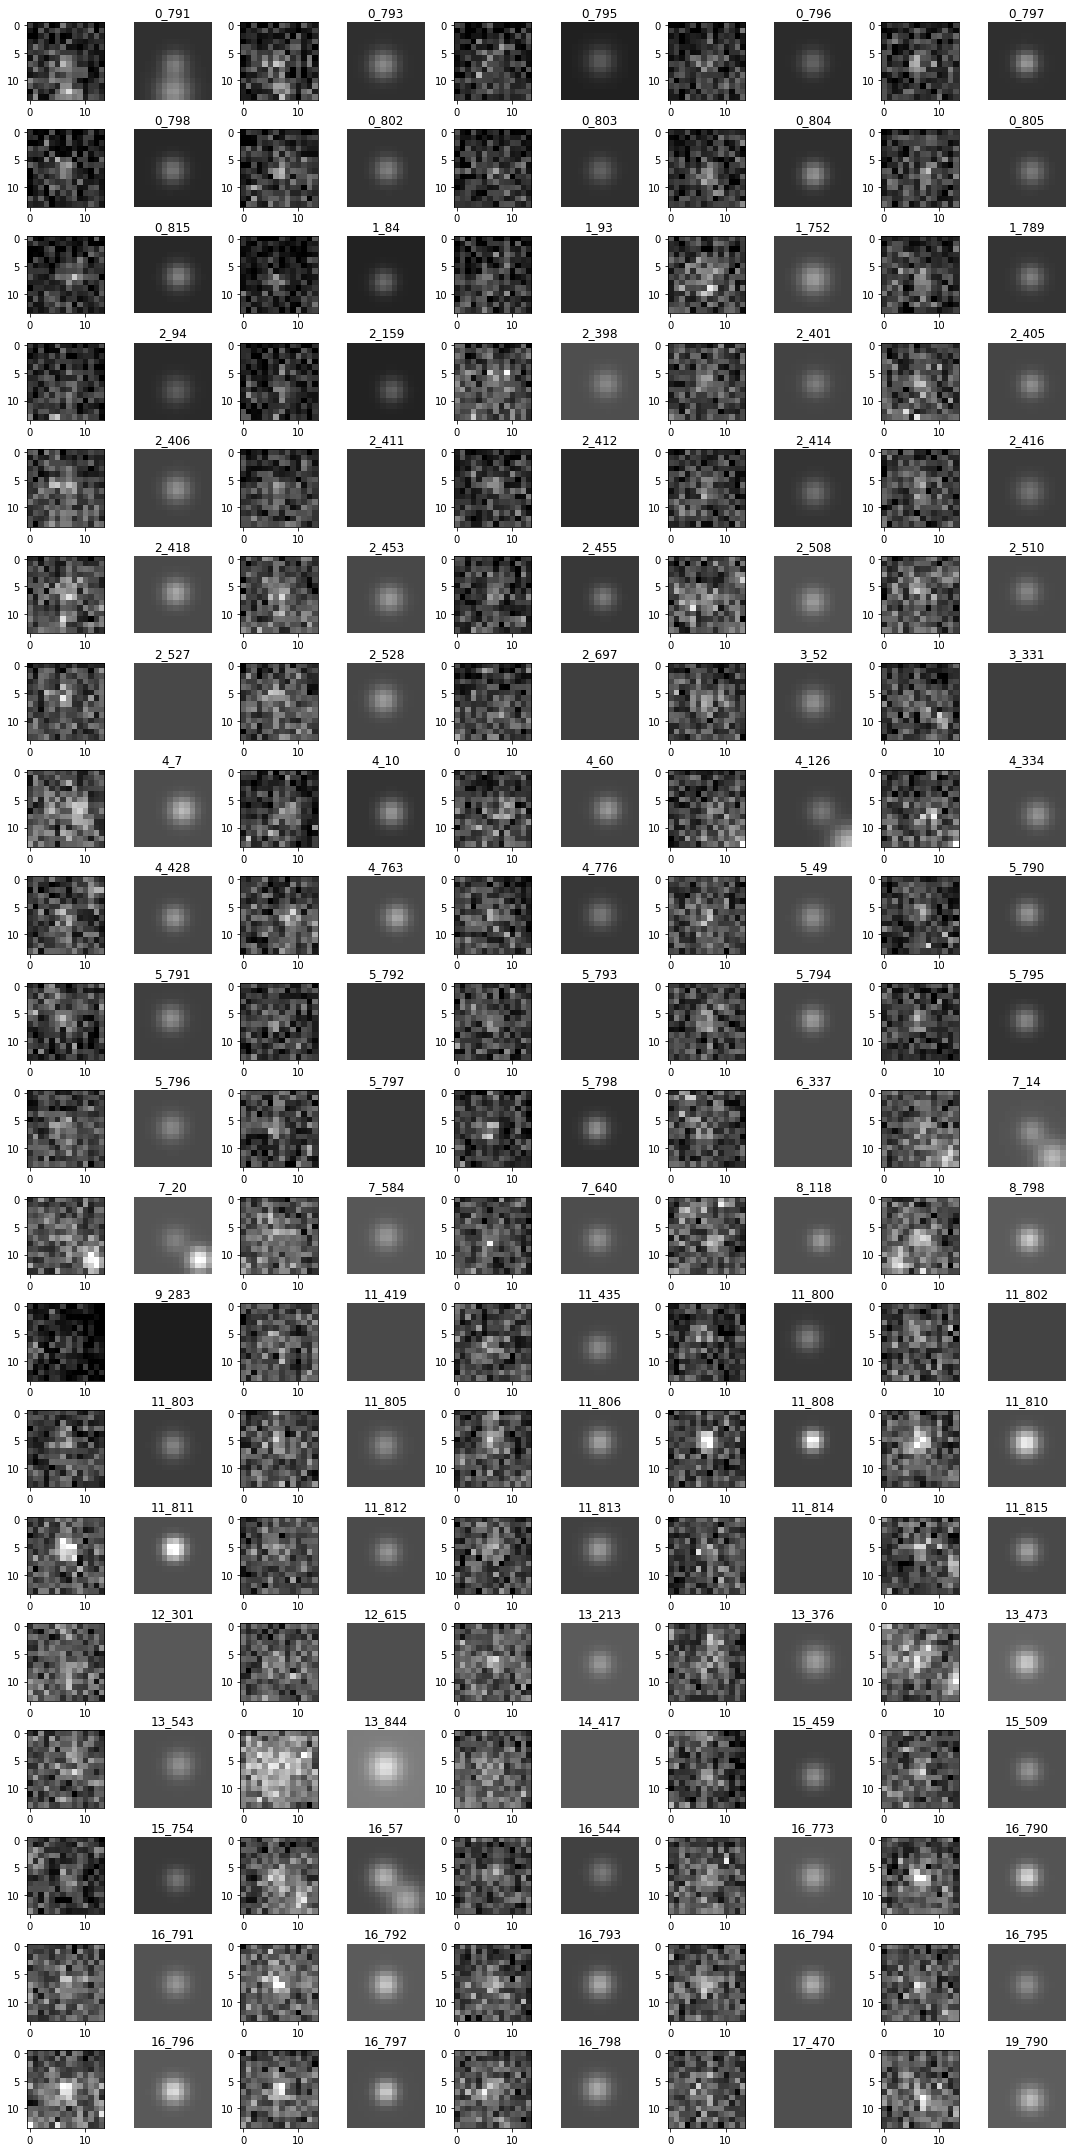

In [35]:
# spots missed by cosmos
mask = (((model.data.labels["z"] == 0) & (model.z_marginal.numpy() > 0.5)))

n, f = np.nonzero(mask)

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,30))
for i in range(min(100, len(result))):
    plt.subplot(20, 10, 2*i+1)
    gaussians = model.data_loc(
    param("d/h_loc").data[n[i], f[i]].masked_fill(model.m_probs[n[i], f[i], :, 1] < 0.5, 0.),
    param("d/w_mean").data[n[i], f[i]],
    param("d/x_mean").data[n[i], f[i]],
    param("d/y_mean").data[n[i], f[i]],
    n[i], f[i]).sum(-3)
    ideal = model.offset_mean + param("d/b_loc").data[n[i], f[i]] + gaussians
    plt.imshow(result[i].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    
    plt.subplot(20, 10, 2*i+2)
    plt.title(f"{n[i]}_{f[i]}")
    plt.imshow(ideal.numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Orange dye attenuated data

In [19]:
snr = np.array([0.63, 0.79, 1.12, 1.41, 1.99, 2.81]) * 2.1 / 2.81
snr = np.array([0.63, 0.79, 1.12, 1.41, 1.99, 2.81])

In [6]:
results = {}
predictions = {}
true_labels = {}
snr = []

names = ["FL_5555_6684_1p3OD", "FL_4445_5554_1p1OD", "FL_3339_4444_0p8OD",
         "FL_2226_3338_0p6OD", "FL_1118_2225_0p3OD", "FL_1_1117_0OD"]

for name in names:
    path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
    path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")
    results[name] = pd.read_csv(
        os.path.join(path_params, "params_last.csv"),
        header=None, squeeze=True, index_col=0)
    predictions[name] = np.load(
        os.path.join(path_params, "predictions.npy"))
    true_labels[name] = np.load(os.path.join(path_data, "labels.npy"))
    
    model = SpotDetection(S=1, K=2)
    model.load(path_data, False, "cpu")
    model.load_parameters(path_params)
    
    snr.append(float(model.snr().mean()))

In [9]:
np.array(snr).mean()

1.8682567874590557

In [16]:
snr

[]

Tracker v1.1.3

In [14]:
results = {}
predictions = {}
true_labels = {}
snr = []

names = ["FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob", "FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob",
         "FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob", "FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob",
         "FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob", "FL_1_1117_0OD_atten_noHysteresis_0p5_prob"]

for name in names:
    path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
    path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")
    results[name] = pd.read_csv(
        os.path.join(path_params, "params_last.csv"),
        header=None, squeeze=True, index_col=0)
    predictions[name] = np.load(
        os.path.join(path_params, "predictions.npy"))
    true_labels[name] = np.load(os.path.join(path_data, "labels.npy"))
    
    #model = SpotDetection(S=1, K=2)
    #model.load(path_data, False, "cpu")
    #model.load_parameters(path_params)
    
    #snr.append(float(model.snr().mean()))

In [5]:
snr

[2.584582805633545,
 3.4128479957580566,
 1.4106535911560059,
 1.9109355211257935,
 1.8737186193466187,
 2.1953511238098145]

In [4]:
scores_v1p13 = pd.DataFrame(data=results).T.drop(columns=[float("nan"), "pi_0", "lamda_0", "width_mode_0", "width_size_0"])
#scores_v1p13["SNR"] = snr
scores_v1p13

,iter,-ELBO,gain,pi_1,lamda_1,MCC,Recall,Precision,FN,TP,TN,FP
FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob,29900.0,27305760.0,1.769059,0.003534,0.026631,0.389858,0.163389,0.947368,553.0,108.0,33744.0,6.0
FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob,29900.0,20433688.0,2.877008,0.014074,0.027418,0.502883,0.266805,0.992268,1058.0,385.0,23013.0,3.0
FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob,29900.0,25251286.0,5.252812,0.023329,0.002412,0.721728,0.591700,0.894737,305.0,442.0,26305.0,52.0
FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob,29900.0,31451082.0,6.725665,0.073904,0.008817,0.927197,0.890618,0.973711,232.0,1889.0,33878.0,51.0
FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob,29900.0,36758332.0,6.801042,0.042468,0.017617,0.941185,0.974702,0.910987,17.0,655.0,35391.0,64.0
FL_1_1117_0OD_atten_noHysteresis_0p5_prob,29900.0,44042968.0,6.901953,0.040881,0.093299,0.880256,0.980422,0.793902,13.0,651.0,41700.0,169.0


In [34]:
scores_sp = pd.DataFrame(data={"spMCC": [matthews_corrcoef(true_labels[name]["z"][true_labels[name]["z"]<2], true_labels[name]["spotpicker"][true_labels[name]["z"]<2]) for name in names],
                   "spRecall": [recall_score(true_labels[name]["z"][true_labels[name]["z"]<2], true_labels[name]["spotpicker"][true_labels[name]["z"]<2]) for name in names],
                   "spPrecision": [precision_score(true_labels[name]["z"][true_labels[name]["z"]<2], true_labels[name]["spotpicker"][true_labels[name]["z"]<2]) for name in names],
                    },
             index=names)
scores_sp

,spMCC,spRecall,spPrecision
FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob,0.428131,0.213740,0.875000
FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob,0.480087,0.244460,0.988796
FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob,0.672745,0.512684,0.899297
FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob,0.893818,0.858968,0.942368
FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob,0.913521,0.961481,0.871141
FL_1_1117_0OD_atten_noHysteresis_0p5_prob,0.845373,0.979651,0.734205


/home/ordabayev/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/ordabayev/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


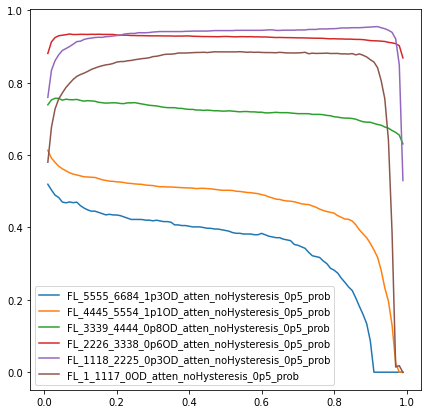

In [35]:
plt.figure(figsize=(7,7))
for name in names:
    mask = true_labels[name]["z"] < 2
    ts = np.arange(0.01,1,0.01)
    mcc = [matthews_corrcoef(true_labels[name]["z"][mask], predictions[name]["z_prob"][mask]>t) for t in ts]
    plt.plot(ts, mcc, label=name)
#plt.ylim(0.8,1)
plt.legend()
plt.show()

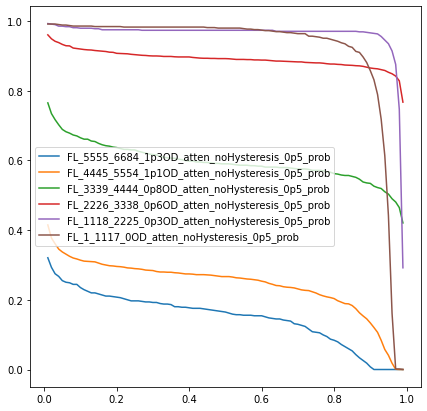

In [55]:
plt.figure(figsize=(7,7))
for name in names:
    mask = true_labels[name]["z"] < 2
    ts = np.arange(0.01,1,0.01)
    mcc = [recall_score(true_labels[name]["z"][mask], predictions[name]["z_prob"][mask]>t) for t in ts]
    plt.plot(ts, mcc, label=name)
#plt.ylim(0.8,1)
plt.legend()
plt.show()

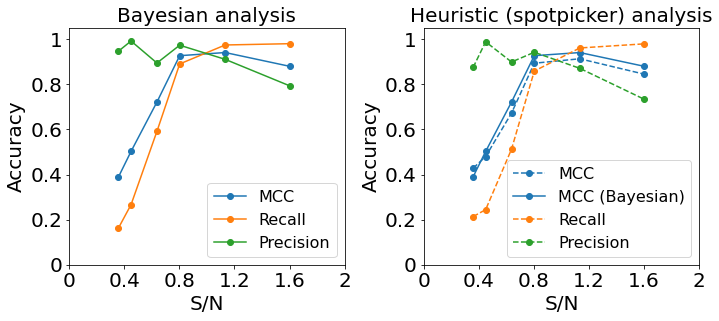

In [40]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.plot(snr, scores_v1p13["MCC"], "o-", label="MCC")
plt.plot(snr, scores_v1p13["Recall"], "o-", label="Recall")
plt.plot(snr, scores_v1p13["Precision"], "o-", label="Precision")

plt.ylim(0,1.05)
plt.xlim(0,1)
plt.xlabel(r"S/N", fontsize=20)
plt.ylabel(r"Accuracy", fontsize=20)
plt.title(r"Bayesian analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(6)*0.4)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=16)

plt.subplot(222)
plt.plot(snr, scores_sp["spMCC"], "o--", label="MCC")
plt.plot(snr, scores_v1p13["MCC"], "o-", color="C0", label="MCC (Bayesian)")
plt.plot(snr, scores_sp["spRecall"], "o--", label="Recall")
plt.plot(snr, scores_sp["spPrecision"], "o--", label="Precision")
plt.ylim(0,1.05)
plt.xlim(0,1)
plt.xlabel(r"S/N", fontsize=20)
plt.ylabel(r"Accuracy", fontsize=20)
plt.title(r"Heuristic (spotpicker) analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(6)*0.4)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=16)


plt.tight_layout()
plt.show()

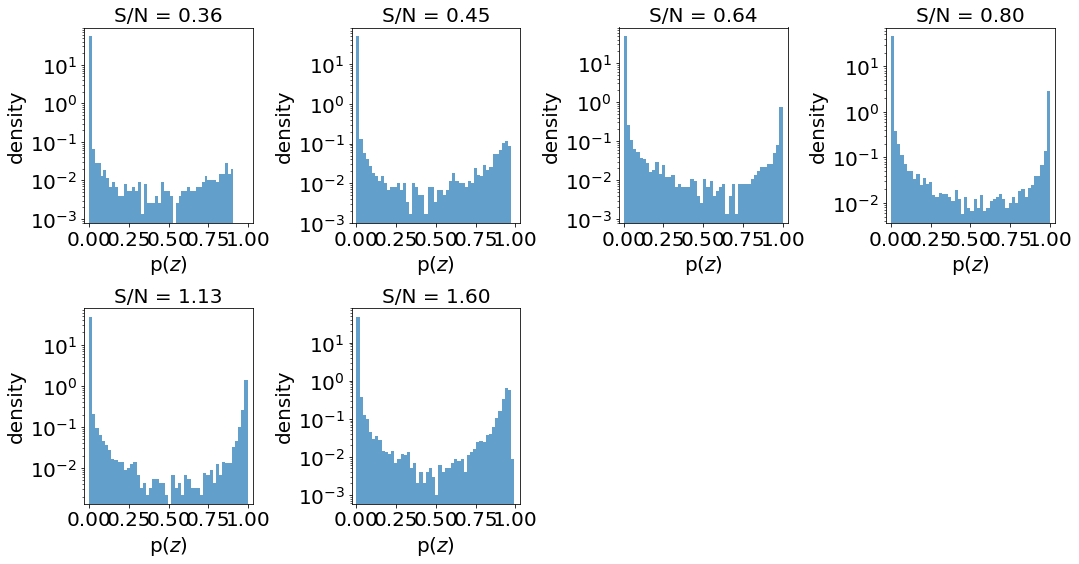

In [41]:
plt.figure(figsize=(15,15))
for i, name in enumerate(names):
    plt.subplot(4, 4, i+1)
    plt.hist(predictions[name]["z_prob"].ravel(), bins=50, density=True, alpha=0.7)
    plt.xlim(-0.03, 1.03)
    #plt.ylim(0, 10)
    plt.yscale('log', nonpositive='clip')
    #plt.gca().axes.get_xaxis().set_ticks([0.8, 0.9, 1])
    #plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlabel(r"p($z$)", fontsize=20)
    plt.ylabel(r"density", fontsize=20)
    plt.title(r"S/N = {:.2f}".format(snr[i]), fontsize=20)

plt.tight_layout()
plt.show()

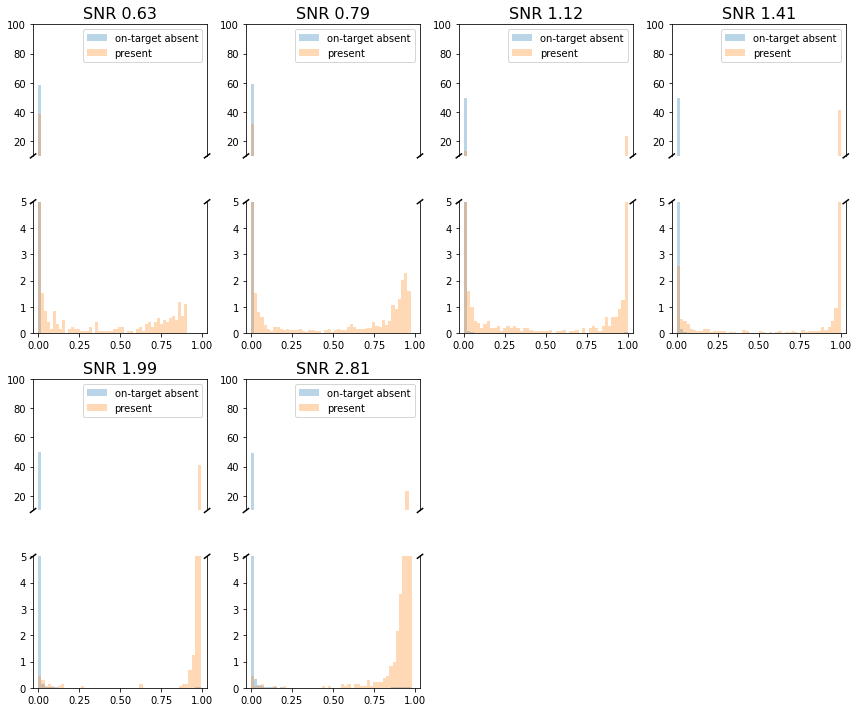

In [20]:
plt.figure(figsize=(12,10))
for i, h in enumerate(names):
    ax = plt.subplot(4, 4, i+1+4*(i//4))
    mask = true_labels[h]["z"] == 0
    ax.hist(predictions[h]["z_prob"][mask], bins=50, density=True, alpha=0.3, label="on-target absent")
    mask = true_labels[h]["z"] == 1
    ax.hist(predictions[h]["z_prob"][mask], bins=50, density=True, alpha=0.3, label="present")
    ax.set_xlim(-0.03, 1.03)
    ax.set_ylim(10, 100.)  # outliers only
    #plt.yscale('log', nonpositive='clip')
    #plt.gca().axes.get_xaxis().set_ticks([0.8, 0.9, 1])
    #plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    #plt.ylim(0,10)
    #plt.xticks(size=20)
    #plt.yticks(size=20)
    #plt.xlabel(r"p($z$)", fontsize=20)
    #plt.ylabel(r"probability density", fontsize=20)
    plt.title(r"SNR {:.2f}".format(snr[i]), fontsize=16)
    plt.legend()
    
    ax2 = plt.subplot(4, 4, i+1+4*(1+i//4))
    mask = true_labels[h]["z"] == 0
    ax2.hist(predictions[h]["z_prob"][mask], bins=50, density=True, alpha=0.3)
    mask = true_labels[h]["z"] == 1
    ax2.hist(predictions[h]["z_prob"][mask], bins=50, density=True, alpha=0.3)
    ax2.set_xlim(-0.03, 1.03)
    ax2.set_ylim(0, 5.)  # most of the data
    
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.set_ticks([])
    ax.tick_params(labeltop='off')  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()
    
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.tight_layout()
plt.show()

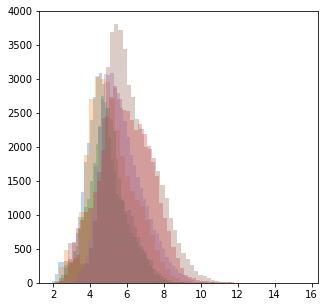

In [83]:
# path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
# path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
    path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    #pyro.get_param_store().load(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
    #    map_location=torch.device("cpu"))
    model = Tracker(S=1, K=2)
    model.load(path_data, False, "cpu")
    model.load_parameters(path_params)
    #snr.append(float(model.snr().mean()))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)
    


    #plt.hist(param("d/h_loc").data[mask].numpy(), bins=50, density=True, alpha=0.3)
    plt.hist(param("d/b_loc").data.flatten().numpy()/param("d/b_beta").data.flatten().numpy(), bins=50, alpha=0.3)
    #plt.hist(np.sqrt(param("d/b_loc").data.flatten().numpy() * param("gain").item() + model.offset_var.item())/14, bins=50, alpha=0.3)
    #plt.hist(param("d/h_loc").data[:, 15:30][mask[:, 15:30]].numpy(), bins=50, alpha=0.3)
    #plt.hist(param("d/h_loc").data[:, 30:45][mask[:, 30:45]].numpy(), bins=50, alpha=0.3)
    #plt.xlim(0, 10000)
plt.show()

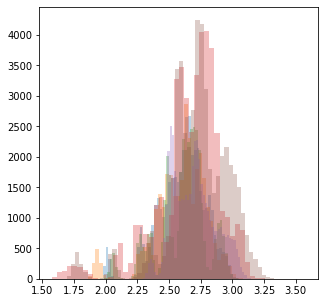

In [84]:
# path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
# path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
    path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    #pyro.get_param_store().load(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
    #    map_location=torch.device("cpu"))
    model = Tracker(S=1, K=2)
    model.load(path_data, False, "cpu")
    model.load_parameters(path_params)
    #snr.append(float(model.snr().mean()))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)
    


    #plt.hist(param("d/h_loc").data[mask].numpy(), bins=50, density=True, alpha=0.3)
    #plt.hist(param("d/b_loc").data.flatten().numpy()/param("d/b_beta").data.flatten().numpy(), bins=50, alpha=0.3)
    plt.hist(np.sqrt(param("d/b_loc").data.flatten().numpy() * param("gain").item() + model.offset_var.item())/14, bins=50, alpha=0.3)
    #plt.hist(param("d/h_loc").data[:, 15:30][mask[:, 15:30]].numpy(), bins=50, alpha=0.3)
    #plt.hist(param("d/h_loc").data[:, 30:45][mask[:, 30:45]].numpy(), bins=50, alpha=0.3)
    #plt.xlim(0, 10000)
plt.show()

tensor(3.3884)
tensor(4.4508)
tensor(8.1861)
tensor(12.1105)
tensor(32.7595)
tensor(68.0718)


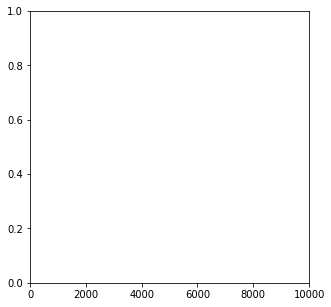

In [10]:
# path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
# path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")

names = ["FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob", "FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob",
         "FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob", "FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob",
         "FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob", "FL_1_1117_0OD_atten_noHysteresis_0p5_prob"]

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, 1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)
    print(param("d/b_loc").data.mean())
    #plt.hist((param("d/h_loc").data / param("d/b_loc").data)[mask].numpy(), bins=50, density=True, alpha=0.3)
    #plt.hist((param("d/h_loc").data / scores_v1p13.loc[name, "atten"])[mask].numpy(), bins=50, density=True, alpha=0.3)
    plt.xlim(0, 10000)
plt.show()

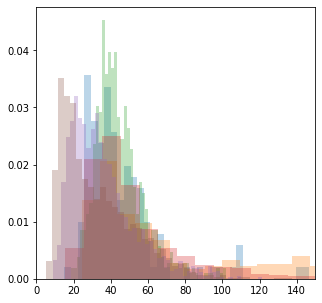

In [70]:
# path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
# path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")

names = ["FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob", "FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob",
         "FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob", "FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob",
         "FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob", "FL_1_1117_0OD_atten_noHysteresis_0p5_prob"]

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, 1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    plt.hist((param("d/h_loc").data / param("d/b_loc").data)[mask].numpy(), bins=50, density=True, alpha=0.3)
    #plt.hist((param("d/h_loc").data / scores_v1p13.loc[name, "atten"])[mask].numpy(), bins=50, density=True, alpha=0.3)
    plt.xlim(0, 150)
plt.show()

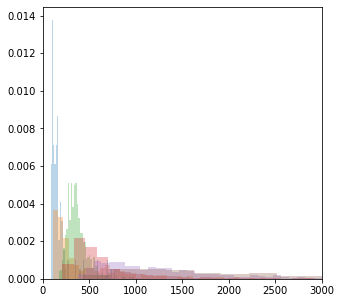

In [63]:
names = ["FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob", "FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob",
         "FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob", "FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob",
         "FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob", "FL_1_1117_0OD_atten_noHysteresis_0p5_prob"]

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, 1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    #plt.hist((param("d/h_loc").data / param("d/b_loc").data)[mask].numpy(), bins=50, density=True, alpha=0.3)
    plt.hist((param("d/h_loc").data)[mask].numpy(), bins=50, density=True, alpha=0.3)
    plt.xlim(0, 3000)
    
x = torch.arange(0,10000.,1)
d1 = dist.Gamma(2190 * 0.0012, 0.0012)
#plt.plot(x, torch.exp(d1.log_prob(x)).cpu(), lw=5)
plt.show()

In [47]:
(param("d/h_loc").data)[mask].mean() / (param("d/h_loc").data)[mask].var()

tensor(0.0012)

In [48]:
(param("d/h_loc").data)[mask].mean()

tensor(2190.9536)

tensor(192.5957, grad_fn=<MeanBackward0>)
tensor(11.8157, grad_fn=<MeanBackward0>)
tensor(195.3535, grad_fn=<MeanBackward0>)
tensor(9.1347, grad_fn=<MeanBackward0>)
tensor(200.2661, grad_fn=<MeanBackward0>)
tensor(11.0746, grad_fn=<MeanBackward0>)
tensor(199.2983, grad_fn=<MeanBackward0>)
tensor(6.2144, grad_fn=<MeanBackward0>)
tensor(215.4230, grad_fn=<MeanBackward0>)
tensor(8.2129, grad_fn=<MeanBackward0>)
tensor(215.7860, grad_fn=<MeanBackward0>)
tensor(7.0940, grad_fn=<MeanBackward0>)


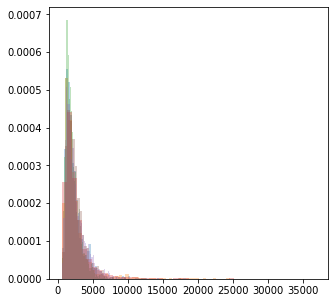

In [87]:
names = ["FL_5555_6684_1p3OD", "FL_4445_5554_1p1OD", "FL_3339_4444_0p8OD",
         "FL_2226_3338_0p6OD", "FL_1118_2225_0p3OD", "FL_1_1117_0OD"]

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, 1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)
    print(param("d/background_loc").mean())
    print(param("d/background_beta").mean())
    #plt.hist((param("d/h_loc").data / param("d/b_loc").data)[mask].numpy(), bins=50, density=True, alpha=0.3)
    plt.hist((param("d/h_loc").data)[mask].numpy(), bins=50, density=True, alpha=0.3)
    #plt.xlim(0, 50)
#x = torch.arange(0,20000.,1)
#d1 = dist.HalfNormal(10000.)
#plt.plot(x, torch.exp(d1.log_prob(x)).cpu(), lw=5)
plt.show()

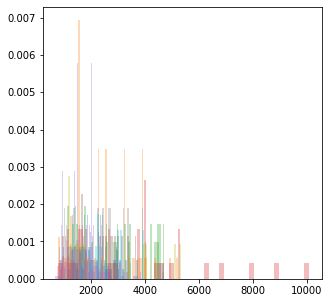

In [13]:
#names = ["FL_5555_6684_1p3OD", "FL_4445_5554_1p1OD", "FL_3339_4444_0p8OD",
#         "FL_2226_3338_0p6OD", "FL_1118_2225_0p3OD", "FL_1_1117_0OD"]
names = ["FL_5555_6684_1p3OD"]

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, 1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
        map_location=torch.device("cpu"))
    for j in range(15):
        mask = param("d/theta_probs").data[j, :, 1:] > 0.5
        mask = mask.permute(1, 0)

        plt.hist((param("d/h_loc").data[:, j])[mask].numpy(), bins=50, density=True, alpha=0.3)
    #plt.xlim(0, 50)
plt.show()

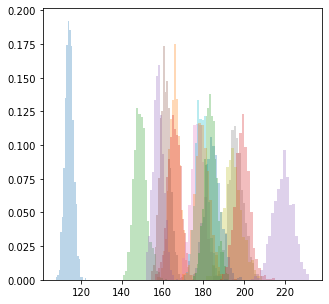

In [10]:
#names = ["FL_5555_6684_1p3OD", "FL_4445_5554_1p1OD", "FL_3339_4444_0p8OD",
#         "FL_2226_3338_0p6OD", "FL_1118_2225_0p3OD", "FL_1_1117_0OD"]
names = ["FL_5555_6684_1p3OD"]

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, 1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    for j in range(15):
        plt.hist(param("d/b_loc").data[j,:].numpy(), bins=20, density=True, alpha=0.3)
    #plt.xlim(0, 50)
plt.show()

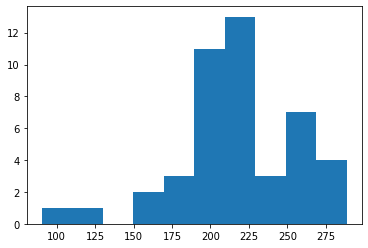

In [11]:
plt.hist(param("d/background_loc").data.numpy())
plt.show()

In [9]:
param("d/background_loc").std()

tensor(38.6722, grad_fn=<StdBackward0>)

In [6]:
param("d/b_loc").data.shape

torch.Size([45, 1117])

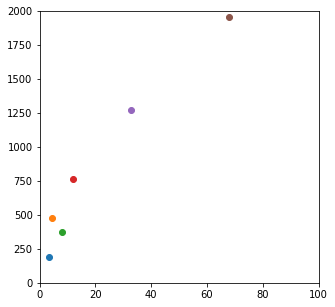

In [25]:
names = ["FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob", "FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob",
         "FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob", "FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob",
         "FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob", "FL_1_1117_0OD_atten_noHysteresis_0p5_prob"]

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, 1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    #plt.hist(param("d/b_loc").data.flatten().numpy(), bins=50, density=True, alpha=0.3)
    plt.scatter(param("d/b_loc").data.mean(), param("d/h_loc").data[mask].mean())
    #plt.hist(param("d/b_loc").data.flatten().numpy() / scores_v1p13.loc[name, "atten"], bins=50, density=True, alpha=0.3)
    plt.xlim(0, 100)
    plt.ylim(0, 2000)
plt.show()

In [18]:
scores_v1p13["atten"] = 1/np.power(10, np.array([1.3, 1.1, 0.8, 0.6, 0.3, 0]))
scores_v1p13

,iter,-ELBO,gain,pi_1,lamda_1,MCC,Recall,Precision,FN,TP,TN,FP,atten
FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob,29900.0,27305760.0,1.769059,0.003534,0.026631,0.389858,0.163389,0.947368,553.0,108.0,33744.0,6.0,0.050119
FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob,29900.0,20433688.0,2.877008,0.014074,0.027418,0.502883,0.266805,0.992268,1058.0,385.0,23013.0,3.0,0.079433
FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob,29900.0,25251286.0,5.252812,0.023329,0.002412,0.721728,0.591700,0.894737,305.0,442.0,26305.0,52.0,0.158489
FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob,29900.0,31451082.0,6.725665,0.073904,0.008817,0.927197,0.890618,0.973711,232.0,1889.0,33878.0,51.0,0.251189
FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob,29900.0,36758332.0,6.801042,0.042468,0.017617,0.941185,0.974702,0.910987,17.0,655.0,35391.0,64.0,0.501187
FL_1_1117_0OD_atten_noHysteresis_0p5_prob,29900.0,44042968.0,6.901953,0.040881,0.093299,0.880256,0.980422,0.793902,13.0,651.0,41700.0,169.0,1.000000


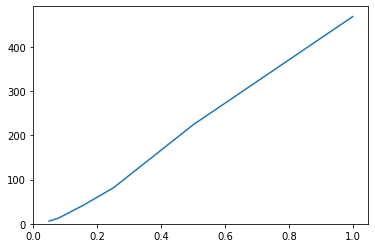

In [65]:
plt.plot(1/np.power(10, np.array([1.3, 1.1, 0.8, 0.6, 0.3, 0])),
         np.array([3.39, 4.45, 8.1, 12.1, 33, 68]) * scores_v1p13["gain"])
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [59]:
np.array([3.39, 4.45, 8.1, 12.1, 33, 68]) * scores_v1p13["gain"]

FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob      5.997110
FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob     12.802684
FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob     42.547780
FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob     81.380548
FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob    224.434389
FL_1_1117_0OD_atten_noHysteresis_0p5_prob         469.332787
Name: gain, dtype: float64